In [1]:
# Magic line to force reload all modules when this cell is run multiple times
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.insert(0, os.path.expanduser("~/Developer/interpretDL/Pipeline"))

In [2]:
# import plotly as py
# import plotly.graph_objs as go
# from plotly.offline import iplot
# from plotly.offline import plot
# import ipywidgets as widgets

# # %matplotlib widget
# py.offline.init_notebook_mode(connected=True)

In [3]:
import numpy as np
import pandas as pd
# import umap

from datetime import datetime
# from ClusterPipeline import ClusterPipeline
from helper import split_valid, plot_confusion_matrix, plot_history
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV

RANDOM_STATE = 42
np.random.seed(seed=RANDOM_STATE) 

In [4]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import TensorBoard

Using TensorFlow backend.
/home/smaug/anaconda3/envs/condatensor/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/smaug/anaconda3/envs/condatensor/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/smaug/anaconda3/envs/condatensor/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np

In [5]:
fname = "data/hr_lr.csv"
raw_data = pd.read_csv(fname, index_col=0).values
raw_data

array([[443.6580811 , 156.8248444 , 157.2230988 , ...,  32.40001297,
         10.53292751,   1.        ],
       [529.8170776 , 301.1605835 , 129.0924835 , ...,  44.31515884,
         12.01620674,   1.        ],
       [689.3991699 , 303.3375244 , 154.1694336 , ...,  63.73936081,
         10.89778328,   1.        ],
       ...,
       [630.8562622 , 303.7183533 , 210.3960266 , ...,  40.54899216,
         17.80297661,   0.        ],
       [479.3210144 , 263.7200623 , 136.6897278 , ...,  42.96739197,
         12.05090141,   0.        ],
       [767.0294189 , 488.8855896 , 134.025528  , ...,  36.10884857,
         15.40684414,   0.        ]])

In [6]:
X = raw_data[:, :-1]
Y = raw_data[:,-1].reshape(-1,1)
X.shape

(164, 333)

In [7]:
ZScaler = StandardScaler().fit(X)
X = ZScaler.transform(X)

## Example run using Grid Search

In [8]:
# Function to create model, required for KerasClassifier
def create_model(nodes=12):
    # create model
    model = Sequential()
    model.add(Dense(nodes, input_dim=333, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='sgd',
                  metrics=['accuracy'])
    return model

In [15]:
%%time
# create model
model = KerasClassifier(build_fn=create_model, verbose=0)
# define the grid search parameters
batch_size = [20]
num_nodes = [64,100,128]   #np.logspace(3, 8, num=6, base=2, dtype=int)
epochs = [500]
param_grid = dict(batch_size=batch_size, epochs=epochs, nodes=num_nodes)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=4, cv=10)
grid_result = grid.fit(X, Y)

/home/smaug/anaconda3/envs/condatensor/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CPU times: user 4.53 s, sys: 162 ms, total: 4.7 s
Wall time: 32.4 s


In [16]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.512195 using {'batch_size': 20, 'epochs': 500, 'nodes': 100}
0.481707 (0.165652) with: {'batch_size': 20, 'epochs': 500, 'nodes': 64}
0.512195 (0.213239) with: {'batch_size': 20, 'epochs': 500, 'nodes': 100}
0.500000 (0.220914) with: {'batch_size': 20, 'epochs': 500, 'nodes': 128}


## DNN Search

In [8]:
def build_dnn(nodes=(150,25), activation="elu", dropout_rate=0.0):
    
    import tensorflow as tf
    import keras
    from keras import optimizers
    from keras import regularizers
    keras.backend.clear_session()
    
    tf.random.set_random_seed(RANDOM_STATE)
    
    reg_scale = 0.01 # For L1 Reg
    my_reg = regularizers.l1(reg_scale) # Can change this if needed
    
    dnn = keras.models.Sequential()

    Dense = keras.layers.Dense

    # Using He initialization
    he_init = keras.initializers.he_normal(seed=RANDOM_STATE)
    
    dnn.add(Dense(units = nodes[0], activation=activation, input_dim=333,
                  kernel_initializer=he_init, kernel_regularizer = regularizers.l1(reg_scale)))
    dnn.add(keras.layers.Dropout(dropout_rate))
    dnn.add(Dense(units = nodes[1], activation=activation,
                  kernel_initializer=he_init, kernel_regularizer = regularizers.l1(reg_scale)))
    dnn.add(keras.layers.Dropout(dropout_rate))
    
    dnn.add(Dense(units=1, activation="sigmoid",
                  kernel_initializer=he_init, kernel_regularizer = my_reg)) # 5 labels -> logits for now
    
    SGD=keras.optimizers.SGD(lr=0.001)
    
    dnn.compile(loss='binary_crossentropy',
                  optimizer=SGD,
                  metrics=['accuracy']) #Internally it seems to be same as binary accuracy
    
    return dnn

In [38]:
# Separating a hold out set that will be used for validation of the pipeline
data_df = pd.DataFrame(X)
labels_df = pd.Series(np.ravel(Y))
X_train, y_train, X_valid, y_valid = split_valid(data_df, labels_df, valid_size=0.2)
class_weight = compute_class_weight("balanced", np.unique(y_train), y_train)
print(X_train.shape)
y_train.value_counts()

(131, 333)


1.0    79
0.0    52
dtype: int64

In [43]:
%%time
dnn = build_dnn()
time = datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir='./logs/{}'.format(time),
                          update_freq="epoch", write_graph=False)  # Very weird bug where TB will stop writing after some epochs...

history = dnn.fit(X_train, y_train, validation_data=(X_valid,y_valid),class_weight=class_weight,
                  epochs=1000, batch_size=20, verbose=0, callbacks=[])

CPU times: user 13 s, sys: 606 ms, total: 13.6 s
Wall time: 7.12 s


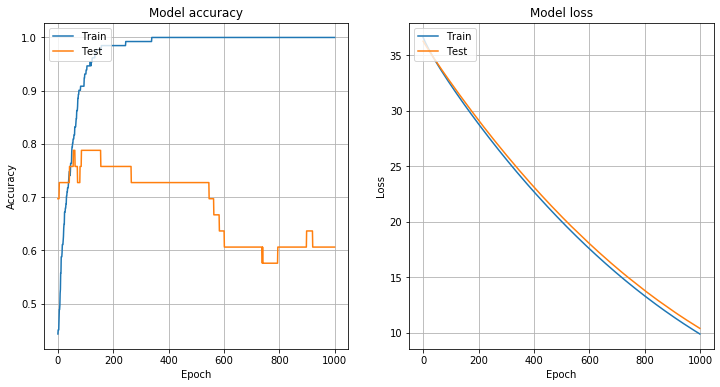

33/33 [==============================] - 0s 40us/step
Loss:10.404, Acc:0.6061


In [44]:
plot_history(history)
print("Loss:{:0.3f}, Acc:{:.4f}".format(*dnn.evaluate(X_valid,y_valid)))

## Architecture Search

In [9]:
exp_2 = np.logspace(4, 8, num=5, base=2, dtype=int)
exp_2_combs = []
for i,x in enumerate(exp_2):
    for j in range(0,i):
        exp_2_combs.append((x,exp_2[j]))
exp_2_combs

[(32, 16),
 (64, 16),
 (64, 32),
 (128, 16),
 (128, 32),
 (128, 64),
 (256, 16),
 (256, 32),
 (256, 64),
 (256, 128)]

### Only searching powers of 2

In [10]:
%%time
# create model
model = KerasClassifier(build_fn=build_dnn, verbose=0)
# define the grid search parameters
batch_size = [1,10,15,20,25]
num_nodes = exp_2_combs   #np.logspace(3, 8, num=6, base=2, dtype=int)
epochs = [100, 150, 200, 250, 300, 400, 500, 1000]
param_grid = dict(batch_size=batch_size, epochs=epochs, nodes=num_nodes)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=8, cv=10)
# grid_result = grid.fit(X, Y)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/home/smaug/anaconda3/envs/condatensor/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)



CPU times: user 1min 21s, sys: 6.09 s, total: 1min 27s
Wall time: 4h 27min 29s


In [11]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%.4f +/- %.3f with: %r" % (mean, stdev, param))

Best: 0.670732 using {'batch_size': 1, 'epochs': 300, 'nodes': (256, 32)}


In [13]:
# for mean, stdev, param in zip(means, stds, params):
#     print("%.4f +/- %.3f with: %r" % (mean, stdev, param))

In [22]:
results = pd.DataFrame(grid_result.cv_results_)
batch_1 = results[results["param_batch_size"]==1]
batch_1

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_epochs,param_nodes,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,11.779642,0.603672,0.037981,0.006318,1,100,"(32, 16)","{'batch_size': 1, 'epochs': 100, 'nodes': (32,...",0.882353,0.529412,...,0.705882,0.7500,0.6250,0.4375,0.3750,0.3125,0.3750,0.585366,0.194119,94
1,14.276489,0.339280,0.039377,0.002844,1,100,"(64, 16)","{'batch_size': 1, 'epochs': 100, 'nodes': (64,...",0.823529,0.529412,...,0.823529,0.8125,0.8125,0.3125,0.3125,0.3125,0.4375,0.579268,0.214567,100
2,15.590874,0.863209,0.043693,0.005187,1,100,"(64, 32)","{'batch_size': 1, 'epochs': 100, 'nodes': (64,...",0.823529,0.529412,...,0.823529,0.8125,0.6875,0.3125,0.2500,0.3125,0.3750,0.554878,0.216851,125
3,23.637362,2.155645,0.057084,0.006718,1,100,"(128, 16)","{'batch_size': 1, 'epochs': 100, 'nodes': (128...",0.941176,0.470588,...,0.764706,0.8125,0.6875,0.3750,0.3125,0.3125,0.3125,0.560976,0.222236,121
4,24.477040,0.625858,0.056899,0.005089,1,100,"(128, 32)","{'batch_size': 1, 'epochs': 100, 'nodes': (128...",0.823529,0.470588,...,0.764706,0.7500,0.6875,0.3125,0.3125,0.3125,0.3750,0.548780,0.198511,143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,288.504443,14.621016,0.069117,0.009607,1,1000,"(128, 64)","{'batch_size': 1, 'epochs': 1000, 'nodes': (12...",0.823529,0.529412,...,0.823529,0.8125,0.8750,0.3750,0.6250,0.3125,0.4375,0.628049,0.194272,33
76,449.889537,24.643113,0.090726,0.010643,1,1000,"(256, 16)","{'batch_size': 1, 'epochs': 1000, 'nodes': (25...",0.823529,0.470588,...,0.823529,0.8125,0.8125,0.3125,0.5625,0.3125,0.3750,0.597561,0.205751,83
77,483.043682,8.366899,0.101175,0.029537,1,1000,"(256, 32)","{'batch_size': 1, 'epochs': 1000, 'nodes': (25...",0.823529,0.470588,...,0.823529,0.8125,0.8750,0.3125,0.6250,0.3125,0.4375,0.615854,0.206450,53
78,525.688910,13.427406,0.102637,0.012288,1,1000,"(256, 64)","{'batch_size': 1, 'epochs': 1000, 'nodes': (25...",0.764706,0.470588,...,0.823529,0.8125,0.8750,0.3125,0.6875,0.3125,0.3750,0.609756,0.208469,65


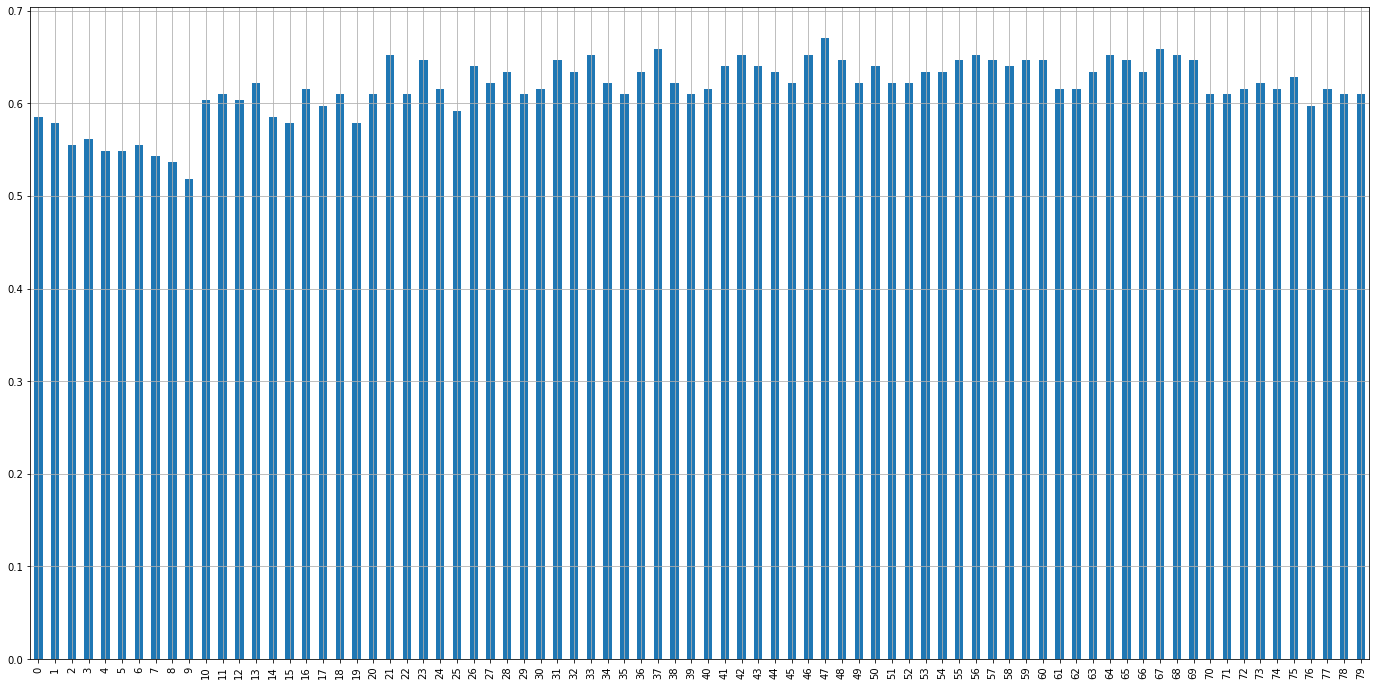

In [24]:
batch_1["mean_test_score"].plot(kind="bar", figsize=(24,12), grid=True)

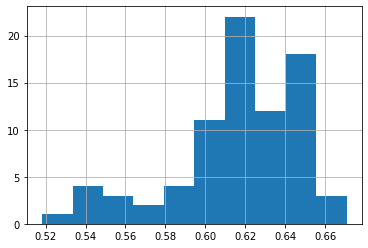

In [25]:
batch_1["mean_test_score"].hist()

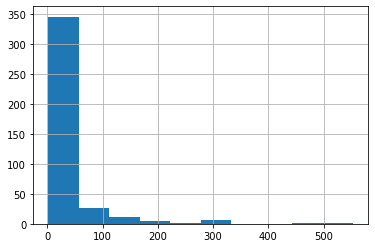

In [27]:
results["mean_fit_time"].hist()

In [32]:
ranked_results = results.sort_values(by="rank_test_score")
batches = {}

In [33]:
for b,_df in ranked_results.groupby(by="param_batch_size"):
    batches[b] = _df

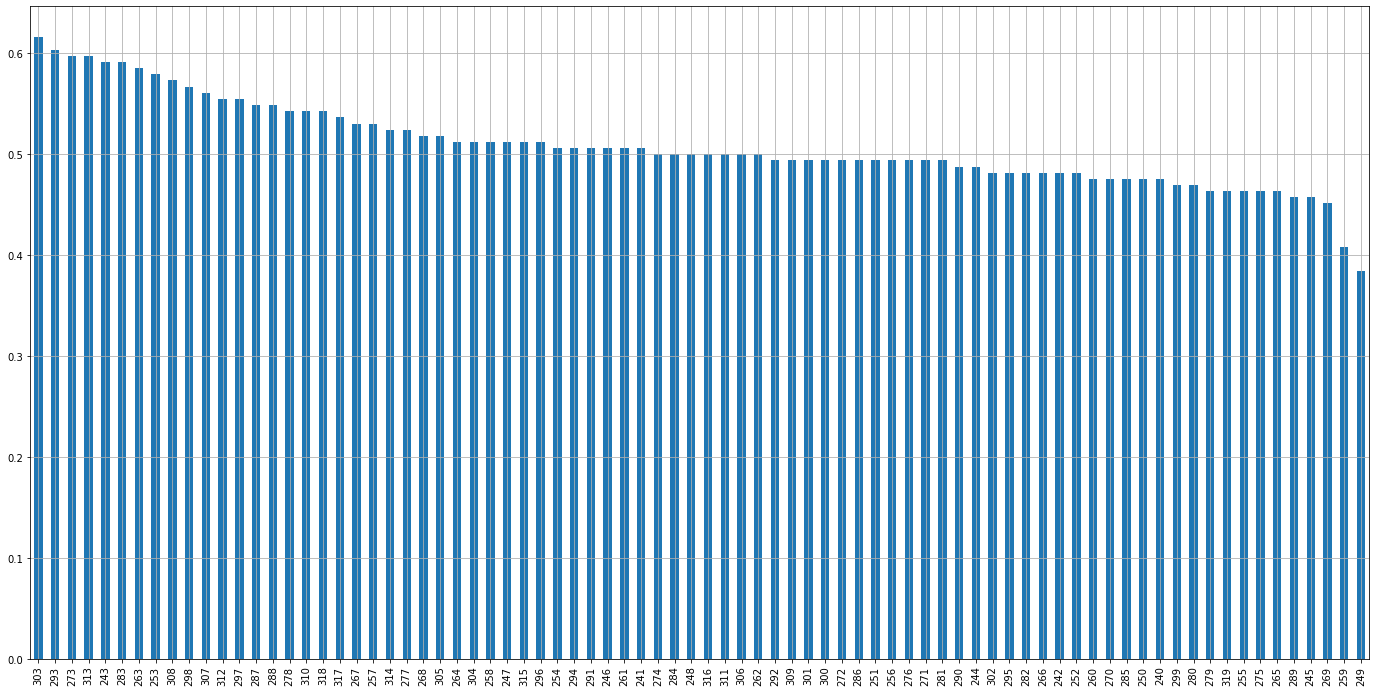

In [44]:
batches[20]["mean_test_score"].plot(kind="bar", figsize=(24,12), grid=True)

In [38]:
for b in batches.keys():
    print(batches[b].iloc[0][["mean_test_score","std_test_score", "mean_fit_time", "params"]])

mean_test_score                                             0.670732
std_test_score                                               0.17625
mean_fit_time                                                146.572
params             {'batch_size': 1, 'epochs': 300, 'nodes': (256...
Name: 47, dtype: object
mean_test_score                                             0.609756
std_test_score                                              0.148871
mean_fit_time                                                8.89974
params             {'batch_size': 10, 'epochs': 300, 'nodes': (12...
Name: 123, dtype: object
mean_test_score                                             0.615854
std_test_score                                              0.146184
mean_fit_time                                                7.88975
params             {'batch_size': 15, 'epochs': 400, 'nodes': (12...
Name: 213, dtype: object
mean_test_score                                             0.615854
std_test_score               

In [45]:
results.to_csv("gs_exp_2_nodes.csv", )

%%time
# create model
model = KerasClassifier(build_fn=build_dnn, verbose=0)
# define the grid search parameters
num_nodes = exp_2_combs   #np.logspace(3, 8, num=6, base=2, dtype=int)

param_grid = dict(batch_size=batch_size, epochs=epochs, nodes=num_nodes)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=8, cv=10)
grid_result = grid.fit(X, Y)

In [254]:
# dnn = build_dnn(num_features=data.shape[1], num_labels=1)
# dnn.summary()

In [278]:
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf

ZScaler = StandardScaler().fit(train_data)
X_train = ZScaler.transform(train_data)
X_valid = ZScaler.transform(test_data)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=100,
                                           verbose=2, mode='max', baseline=None, restore_best_weights=True)

y_train = train_labels.values.reshape(-1,1)
y_valid = test_labels.values.reshape(-1,1)

class_weight = compute_class_weight("balanced", np.unique(train_labels), train_labels)

## Batch size: 10